# Coupled Simple Land Simulations

##### Marysa M Laguë
##### 2017.02.22

## Comparison of coupled simulations using maps and vertical cross sections to look at how various pertubations of albedo, height, evaporative resistance, and soil heat capacity change selected variables.

## Setup 
(This section just has code needed to manipulate the netcdf files, make plots, load data, etc)

### modules


In [ ]:
reset


In [1]:
# For interactive in-line plots:
#%matplotlib nbagg  

# For inline plots:
%matplotlib inline     

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
import scipy.io as sio
#import cpickle as pickle
import pickle as pickle

import time

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import brewer2mpl as cbrew

# OS interaction
import os
import sys

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

### Directories

In [3]:
##### Directory Lists
## Unix
#if 'linux' in sys.platform:
#    dir_pre = '/home/lapok/gdrive/'
## Mac
#elif 'darwin' in sys.platform:
#    dir_pre = '/Users/karllapo/gdrive/'

# My local root directory
dir_root = '/home/disk/eos3/mlague/'

# Where, wrt root, to find the data and save the plots
dir_data = dir_root + '/cesmruns/SimpleLand/global_pert/'
dir_fig = dir_root + '/simple_land/scripts/python/analysis/global_pert/figures/albedo_sims/'

# Names of the albedo simulations
#sims = ['global_a2_cv2_hc1_rs100',
#       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100']
sims = ['global_a2_cv2_hc1_rs100',
       'global_a1_cv2_hc1_rs100','global_a3_cv2_hc1_rs100',
       'global_a2_cv1.5_hc1_rs100','global_a2_cv3_hc1_rs100',
       'global_a2_cv2_hc0.5_rs100','global_a2_cv2_hc10_rs100',
       'global_a2_cv2_hc1_rs30','global_a2_cv2_hc1_rs200']

#load the file paths and # Open the coupled data sets in xarray
cam_files = {}
clm_files = {}
ds_cam = {}
ds_clm = {}

for run in sims:
    #print ( ext_dir + run + '/means/' + run + '.cam.h0.05-end_year_avg.nc' )
    cam_files[run] = dir_data + run + '/means/' + run + '.cam.h0.05-end_year_avg.nc'
    clm_files[run] = dir_data + run + '/means/' + run + '.clm2.h0.05-end_year_avg.nc'
    
    ds_cam[run] = xr.open_dataset(cam_files[run])
    ds_clm[run] = xr.open_dataset(clm_files[run])


# open a cam area file produced in matlab using an EarthEllipsoid from a cam5 f19 lat/lon data set
area_f19_mat = sio.loadmat('/home/disk/eos3/mlague/simple_land/scripts/python/analysis/f19_area.mat')
area_f19 = area_f19_mat['AreaGrid']


#

/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:389: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/disk/p/mlague/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:408: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


### Functions

##### Plotting

## Maps:

### Pickle a map projection, because it is very slow to make one from scratch

In [4]:
def make_basemap():
    
    dsa = ds_cam['global_a2_cv2_hc1_rs100']
    lat = dsa['lat'].values
    lon = dsa['lon'].values
    dsl = ds_clm['global_a2_cv2_hc1_rs100']
    landmask = dsl['landmask'].values
    
    LN,LT = np.meshgrid(lon,lat)
    
    
    # Make a basic basemap robin projection; this centres the Pacific, which isn't ideal, but 
    # I'll need to roll the data around 180 degrees to make it play nice I think...
    t1 = time.clock()
    
    fig = plt.figure()
    
    mp = Basemap(projection='robin',ellps='WGS84',lon_0=180.,lat_0=0.,resolution='c');
    mp.drawcoastlines()
    #mp.drawcountries()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    
    #with open(basemap_pkl, 'w') as f:
    #        pickle.dump(mp, f, pickle.HIGHEST_PROTOCOL)
            
    # Pickle the basemap for use later
    #pickle.dump(mp,open(dir_fig + 'map.pickle','wb'),-1)  # pickle it 

    #plt.clf

    print(time.clock()-t1,' secs to create original Basemap instance')
    
    return mp
    # dispose of mp so we don't accidentally use it later. 
    #del mp
    # load the pickle in later:
    # mp = pickle.load( open( dir_fig + 'map.pickle', 'rb' ) )
    
def get_basemap():
    with open(basemap_pkl, 'r') as f:
            return pickle.load(f)
    return mp



In [5]:

def mml_fig(LN,LT,mapdata,ds,myvar,proj=None,title=None,clim=None,colmap=None,units=None):
    #x_data, y_data, x_label, y_label, title=None, xlim=None, ylim=None
    ''' Desctiption of function goes here. Also, single and double quotes are the same...'''

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0, ellps='WGS84',resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('units: '+ds[myvar].units)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return fig, mp, ax, cbar, cs

def mml_map(LN,LT,mapdata,ds,myvar,proj,title=None,clim=None,colmap=None,cb_ttl=None):
    # need to have already opened a figure/axis
    #plt.sca(ax)
    
    # There is a way to make a single basemap, save it, and just call that vover and over, ie a blank little map, 
    # that we then build maps on top of (pcolours)
    mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0,resolution='c') # can't make it start anywhere other than 180???
    mp.drawcoastlines()
    mp.drawmapboundary(fill_color='1.')  # make map background white
    parallels = np.arange(-90.,90,20.)
    mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
    meridians = np.arange(0.,360.,20.)
    mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])
    #(x, y) = m(LONXY, LATXY)
    cs = mp.pcolormesh(LN,LT,mapdata,cmap=plt.cm.inferno,latlon=True)
    
    if cm:
        cs.cmap = colmap
    else:
        cs.cmap = plt.cm.inferno    
    
    cbar = mp.colorbar(cs,location='bottom',pad="5%")
    
    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=12)
    else:
        cbar.set_label('units: '+ds[myvar].units,fontsize=12)
    
    if title:
        plt.title(title,fontsize=12)
    else:
        plt.title(ds[myvar].long_name,fontsize=12)
    
    if clim:
        cbar.set_clim(clim[0],clim[1])
        cs.set_clim(clim[0],clim[1])
    
    
    
    
    #plt.suptitle('units?')
    #plt.show()
    
    
    #plt.show()
    return fig, mp, ax, cbar, cs 



In [6]:
def zonal_fig(data,lat,lev,ds,var,ttl,levels,title=None,clim=None,colmap=None,units=None):
    
    fig = plt.figure(figsize=(6,6))
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    
    mp = plt.contourf(np.sin(lat*np.pi/180),lev,data,levels,cmap=colmap)
    
    mp.set_clim(vmin=clim[0],vmax=clim[1])

    #mp.colorbar()
    #cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
    #cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
    cbar = plt.colorbar(mp)
    #cbar = 
    cbar.set_label(units,fontsize=20)
    #cbar.set_clim(vmin=clim[0],vmax=clim[1])
    #cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
    
    plt.title(ttl)
    plt.ylabel('Pressure [hPa]')
    plt.xlabel('Latitude [degrees N]')

    tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
    tx_name = ['-90','-60','-30','0','30','60','90']
    ax0.set_xticks(tx)
    ax0.set_xticklabels(tx_name)
 
    return mp, cbar

In [7]:
dsa = ds_cam['global_a2_cv2_hc1_rs100']
lat = dsa['lat'].values
lon = dsa['lon'].values
dsl = ds_clm['global_a2_cv2_hc1_rs100']
landmask = dsl['landmask'].values
    
LN,LT = np.meshgrid(lon,lat)
    

# Albedo perturbations

### Plot temperature and clouds, to show what it is we're interested in diagnosing. 
Here, I'm just going to look at the a1-a3 case (darkest - lightest)

### Temperature

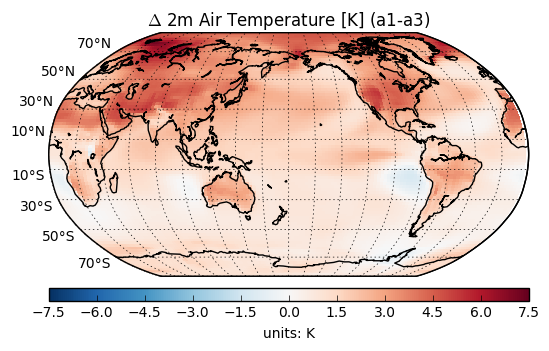

In [8]:
var = 'TREFHT'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ 2m Air Temperature [K] (a1-a3)'
filename = var

clim_abs = [220,320]
clim_diff = [-7.5,7.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


Alrighty, no surprises here - make the land darker $\Rightarrow$ the land gets warmer. Only exception is the cooling we see offshore of South America, but we know there is a big low cloud change there. 

For completeness, lets also take a look at the surface temepratures. 

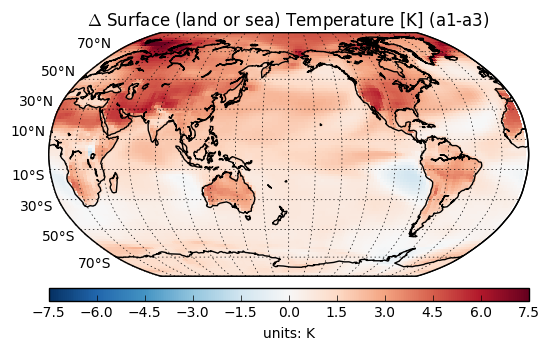

In [10]:
var = 'TS'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ Surface (land or sea) Temperature [K] (a1-a3)'
filename = var

clim_abs = [220,320]
clim_diff = [-7.5,7.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


The surface 

### Cloud (total, low, high)

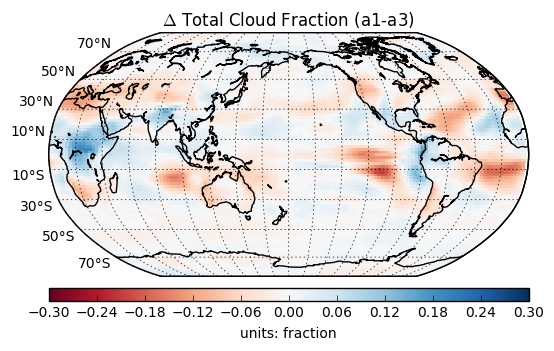

In [11]:
var = 'CLDTOT'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ Total Cloud Fraction (a1-a3)'
filename = var

clim_abs = [220,320]
clim_diff = [-.3,.3]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


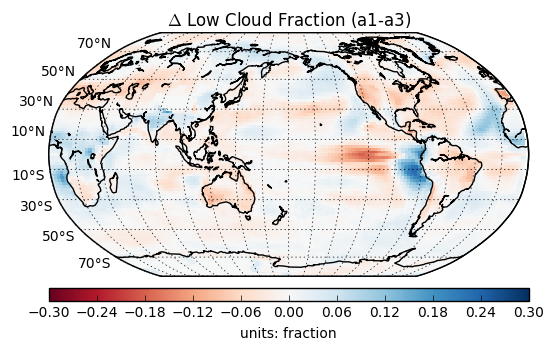

In [12]:
var = 'CLDLOW'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ Low Cloud Fraction (a1-a3)'
filename = var

clim_abs = [220,320]
clim_diff = [-.3,.3]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


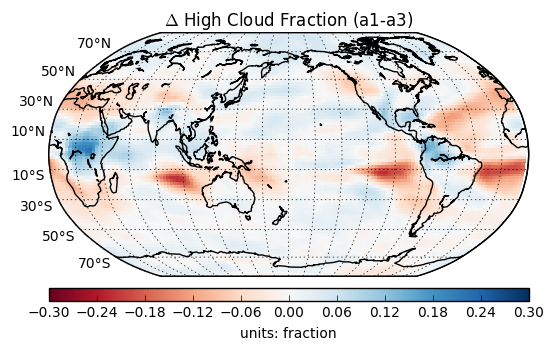

In [13]:
var = 'CLDHGH'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ High Cloud Fraction (a1-a3)'
filename = var

clim_abs = [220,320]
clim_diff = [-.3,.3]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


### Subsidence at 700 hPa

(30, 96, 144)
(96, 144)
0.0870459


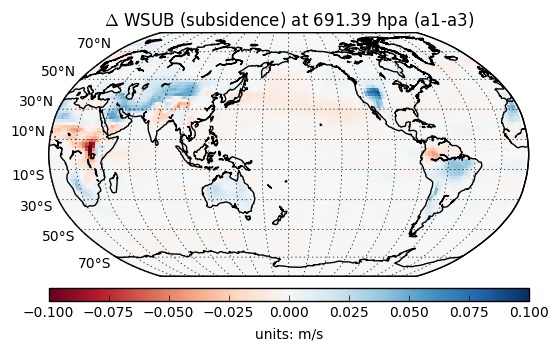

In [17]:
var = 'WSUB'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

lev = ds1['lev'].values

units = ds1[var].units

h=20

hpa = ds1['lev'][20]

ttl_main = '$\Delta$ WSUB (subsidence) at ' + '%.2f' % lev[h] + ' hpa (a1-a3)'
filename = var+ '%.2f' % lev[h]


clim_abs = [220,320]
clim_diff = [-0.1,0.1]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
print(np.shape(mapdata_nan))
mapdata_nan = mapdata_nan[20,:,:].squeeze()
print(np.shape(mapdata_nan))
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


3.57406e-08


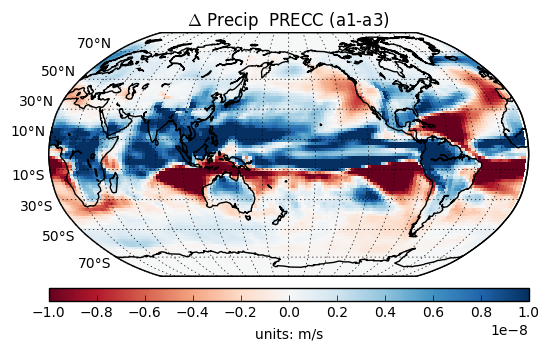

In [19]:
var1 = 'PRECC'
var2 = 'PRECL'
var = var1

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ Precip  PRECC (a1-a3)'
filename = var



clim_abs = [220,320]
clim_diff = [-1e-8, 1e-8]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = (ds1.mean('time')[var1].values.squeeze() + ds1.mean('time')[var2].values.squeeze()) - ( ds2.mean('time')[var1].values.squeeze() + ds2.mean('time')[var2].values.squeeze())
mapdata_nan = (ds1.mean('time')[var1].values.squeeze() ) - ( ds2.mean('time')[var1].values.squeeze() )
#mapdata_nan = (ds1.mean('time')[var2].values.squeeze()) - (  ds2.mean('time')[var2].values.squeeze())


mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata_nan))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


4.37446e-08


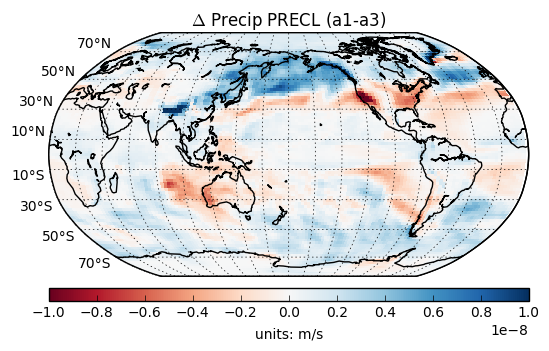

In [20]:
var1 = 'PRECC'
var2 = 'PRECL'
var = var1

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ Precip PRECL (a1-a3)'
filename = var



clim_abs = [220,320]
clim_diff = [-1e-8, 1e-8]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
#mapdata_nan = (ds1.mean('time')[var1].values.squeeze() + ds1.mean('time')[var2].values.squeeze()) - ( ds2.mean('time')[var1].values.squeeze() + ds2.mean('time')[var2].values.squeeze())
#mapdata_nan = (ds1.mean('time')[var1].values.squeeze() ) - ( ds2.mean('time')[var1].values.squeeze() )
mapdata_nan = (ds1.mean('time')[var2].values.squeeze()) - (  ds2.mean('time')[var2].values.squeeze())


mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata_nan))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


6.84261e-08


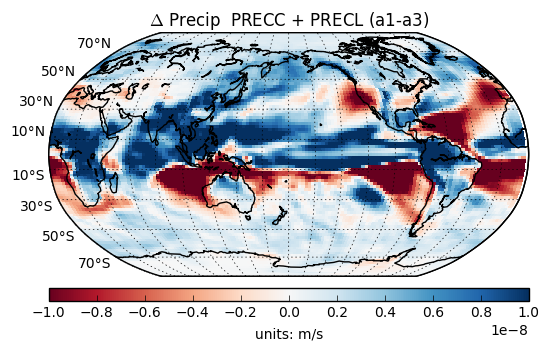

In [21]:
var1 = 'PRECC'
var2 = 'PRECL'
var = var1

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

ttl_main = '$\Delta$ Precip  PRECC + PRECL (a1-a3)'
filename = var



clim_abs = [220,320]
clim_diff = [-1e-8, 1e-8]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = (ds1.mean('time')[var1].values.squeeze() + ds1.mean('time')[var2].values.squeeze()) - ( ds2.mean('time')[var1].values.squeeze() + ds2.mean('time')[var2].values.squeeze())
#mapdata_nan = (ds1.mean('time')[var1].values.squeeze() ) - ( ds2.mean('time')[var1].values.squeeze() )
#mapdata_nan = (ds1.mean('time')[var2].values.squeeze()) - (  ds2.mean('time')[var2].values.squeeze())


mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata_nan))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


    Check where I'm putting the cross section:

-0.947368421053
312.5
200.0


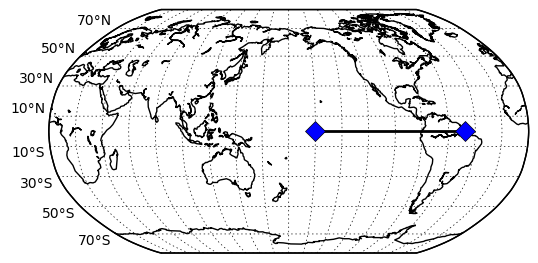

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
mp = Basemap(projection='robin',lon_0=180.,lat_0 = 0) # can't make it start anywhere other than 180???
mp.drawcoastlines()
mp.drawmapboundary(fill_color='1.')  # make map background white
parallels = np.arange(-90.,90,20.)
mp.drawparallels(parallels,labels=[1,0,0,0],fontsize=10,linewidth=0.5,dashes=[1,2])
meridians = np.arange(0.,360.,20.)
mp.drawmeridians(meridians,linewidth=0.5,dashes=[1,2])

x, y = mp(160,0)
#mp.plot(x,y,marker='D',color='m')
#mp.plot([ds1.lat.values[47],ds1.lat.values[72]],[ds1.lon.values[47],ds1.lon.values[47]],'D-', markersize=10, linewidth=2, color='k', markerfacecolor='b')
print(ds1.lat.values[47])
print(ds1.lon.values[125])
print(ds1.lon.values[80])

lon_temp = [ds1.lon.values[80], ds1.lon.values[125]]
lat_temp = [0, 0]
x, y = mp(lon_temp,lat_temp)
mp.plot(x,y,'D-', markersize=10, linewidth=2, color='k', markerfacecolor='b')

plt.show()

### vertical cross section Figures

Plot a zonal cross section at the equator across South America and the Eastern Pacific to see what is happening with RH at different heights

-0.947368421053
200.0
312.5
(30, 45)
15.9033


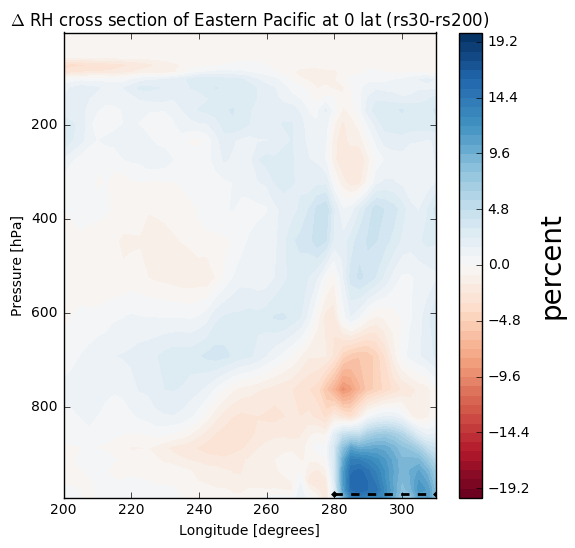

In [19]:
var = 'RELHUM'

#print(ds1.var)

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ RH cross section of Eastern Pacific at 0 lat (a1-a3)'
ttl = '$\Delta$ RH cross section of Eastern Pacific at 0 lat (rs30-rs200)'

filename = var+'_cross_section'


clim_abs = [0,100]
clim_diff = [-20, 20]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#
#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

-0.947368421053
200.0
312.5
(30, 45)
20.4281


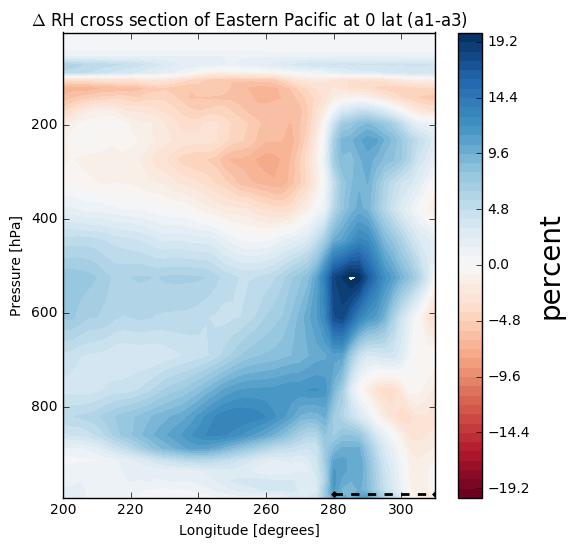

In [20]:
var = 'RELHUM'

#print(ds1.var)

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ RH cross section of Eastern Pacific at 0 lat (a1-a3)'
#ttl = '$\Delta$ RH cross section of Eastern Pacific at 0 lat (rs30-rs200)'

filename = var+'_cross_section'


clim_abs = [0,100]
clim_diff = [-20, 20]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#
#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

-0.947368421053
200.0
312.5
(30, 45)
0.139799
[200.0, 305.0]


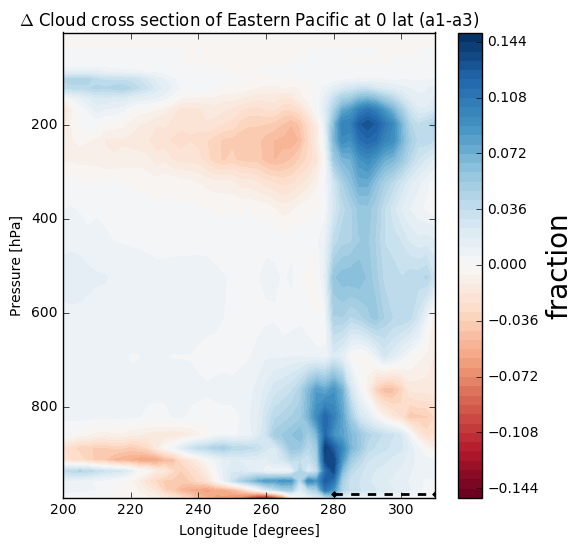

In [21]:
var = 'CLOUD'

#print(ds1.var)

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ Cloud cross section of Eastern Pacific at 0 lat (a1-a3)'
filename = var+'_cross_section'


clim_abs = [0,1]
clim_diff = [-0.15, 0.15]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

print([lon[xlon1],lon[xlon2-3]])

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#mp.plot([xlon1,xlon2],[950,950],'D-', markersize=10, linewidth=2, color='k', markerfacecolor='b')


#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

-0.947368421053
200.0
312.5
(30, 45)
0.125642
[200.0, 305.0]


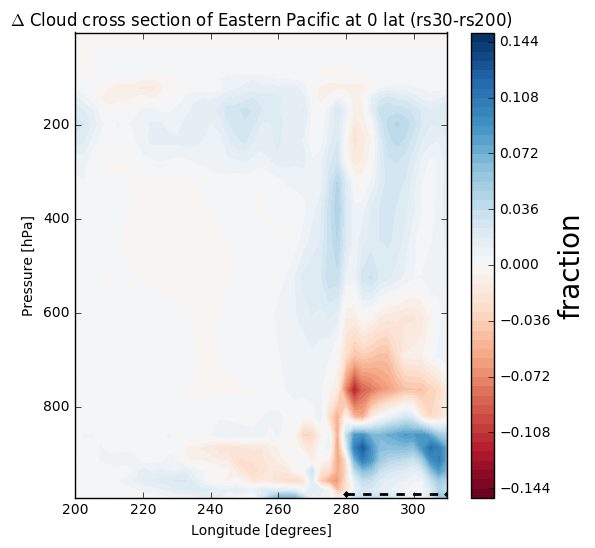

In [22]:
var = 'CLOUD'

#print(ds1.var)

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ Cloud cross section of Eastern Pacific at 0 lat (rs30-rs200)'
filename = var+'_cross_section'


clim_abs = [0,1]
clim_diff = [-0.15, 0.15]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

print([lon[xlon1],lon[xlon2-3]])

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#mp.plot([xlon1,xlon2],[950,950],'D-', markersize=10, linewidth=2, color='k', markerfacecolor='b')


#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

-0.947368421053
200.0
312.5
(30, 45)
3.24011
[200.0, 305.0]


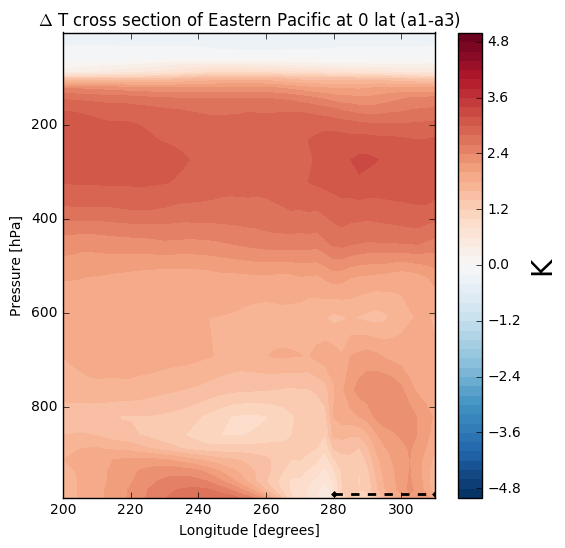

In [23]:
var = 'T'

#print(ds1.var)

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ T cross section of Eastern Pacific at 0 lat (a1-a3)'
filename = var+'_cross_section'


clim_abs = [0,1]
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

print([lon[xlon1],lon[xlon2-3]])

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#mp.plot([xlon1,xlon2],[950,950],'D-', markersize=10, linewidth=2, color='k', markerfacecolor='b')


#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

Shouldn't this have cooled near the sfc, where the clouds are? TS cooled... 

936.198398471
(30, 96, 144)
(96, 144)
3.34739


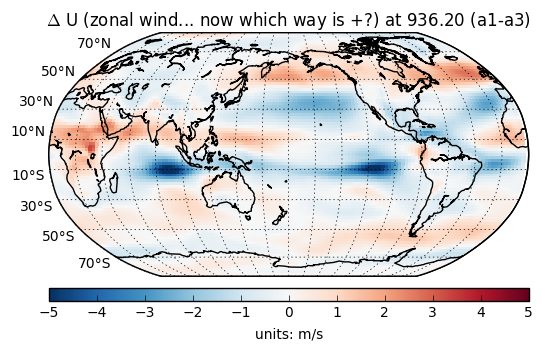

In [24]:
var = 'U'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

print(lev[26])

h = 26

hpa = ds1['lev'][h]

ttl_main = '$\Delta$ U (zonal wind... now which way is +?) at ' + '%.2f' % lev[h] + ' (a1-a3)'
filename = var+ '%.2f' % lev[h]


clim_abs = [220,320]
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
print(np.shape(mapdata_nan))
mapdata_nan = mapdata_nan[h,:,:].squeeze()
print(np.shape(mapdata_nan))
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


In [25]:
print(lev)

[   3.64346569    7.59481965   14.35663225   24.61222      38.26829977
   54.59547974   72.01245055   87.82123029  103.31712663  121.54724076
  142.99403876  168.22507977  197.9080867   232.82861896  273.91081676
  322.24190235  379.10090387  445.9925741   524.68717471  609.77869481
  691.38943031  763.40448111  820.85836865  859.53476653  887.02024892
  912.64454694  936.19839847  957.48547954  976.32540739  992.55609512]


912.644546945
(30, 96, 144)
(96, 144)
5.33719


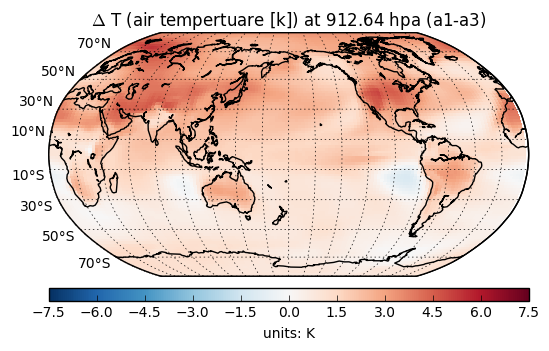

In [26]:
var = 'T'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

print(lev[25])

h = 25;

hpa = ds1['lev'][h]

ttl_main = '$\Delta$ T (air tempertuare [k]) at ' + '%.2f' % lev[h] + ' hpa (a1-a3)'
filename = var+ '%.2f' % lev[h]


clim_abs = [220,320]
clim_diff = [-7.5,7.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
print(np.shape(mapdata_nan))
mapdata_nan = mapdata_nan[h,:,:].squeeze()
print(np.shape(mapdata_nan))
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


## Now try to calculate EIS (Estimated Inversion Strength)
Calculated following Wood and Bretherton 2006 ("On the Relationship between Stratiform Low Cloud Cover and Lower-Tropospheric Stability"):

From eq. (4) of that paper:
$$ EIS = LTS - \Gamma_m^{850}(z_{700}-LCL)$$
$\Gamma_m(T,p) $ is from eq (5): 
$$ \Gamma_m(T,p) = \frac{g}{c_p}\bigg( 1 - \frac{ 1 + L_v q_x(T,p) / (R_a T) }{ 1 + L_v^2 q_s(T,p) / (c_p R_v T^2) } \bigg),$$
where $L_v$ is the latent heat of vaporization, $q_s$ is the saturation mixing ratio, $R_a$ and $R_v$ are the gas constants for dry air and water vapour, respectively, g is the graviational acceleration, and $c_p$ is the specific heat of air at constant pressure. The values used in our calculation are as follows:

$L_v = 2.501e6$ [J/kg] 

$c_p = 1005.0$ [J/kg/K] (dry air... its 1846.0 for wet air, which am I supposed to use?)

$g = 9.81$ [m/s$^2$]

$R = 8.31446$ [J/K/mol], universal gas constant

$R_a = 287.058 $ [J/kg/K] ($R_a = R/M$, $M$ is the molar mass of (dry) air)

$R_v = 461.5$ [J/kg/K]

$T$ [K] is the temperature at $850$ hpa (?)

$p$ [hpa] is the 850 pressure (850) 

$q_s(T,p) = $ [kg/kg]

To calculate the saturation mixing ratio, I've gone back to Wallace and Hobbs for help...
$$ q_s(T,p) = w_s(T,p) = 0.622 \frac{e_s}{p}, $$
aaaand to Petty's thermodynamics book to grab a Clasius Claperyon eq'n for $e_s$:
$$ e_s(T) = 611.2 \exp{\bigg( \frac{17.67 T_c}{T_c + 243.4} \bigg)}$$
(for $T_c = T$ in Celsius! - also eq 3.63 in Wallace and Hobbs)

The Wood & Bretherton [2006] paper says "standard procedures exist to calculate the $LCL$ from $T_0$, $p_0$, and $RH_0$". In order for me to calculate the $LCL$, I'll have to go look up those standard procedures. 




EIS: gather required terms 
ds1.mean('time')

In [ ]:
# constants:

Lv = 2.501*10**6   # [J/kg]
cp = 1005.0        # {J/kg/K}
g = 9.81           # [m/s2]
Ra = 287.058       # [J/kg/K]
Rv = 461.5         # [J/kg/K]


In [73]:
var = 'EIS'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

lev = ds1.variables['lev'].values
h1 = 23
h2 = 20
print(lev[h1],lev[h2])
# We'll use 859 rather than 850, because its the closest level we've got, and 691 rather tahn 700 for z_100

p1 = lev[h1];
p2 = lev[h2];

# 850 hPa Temeperature, in Celsius 
T850_1 = ds1.mean('time').variables['T'].values[h1,:,:].squeeze() - 273.15
T850_2 = ds2.mean('time').variables['T'].values[h1,:,:].squeeze() - 273.15

# 700 hPA Geopotential height, in m
z700_1 = ds1.mean('time').variables['Z3'].values[h2,:,:].squeeze()
z700_2 = ds2.mean('time').variables['Z3'].values[h2,:,:].squeeze()

# Clasius Clapeyron saturation vapour pressure
es1 = 611.2 exp( 17.76*T850_1 / (T850_1 + 243.4) )
es2 = 611.2 exp( 17.76*T850_2 / (T850_2 + 243.4) )

# Saturation mixing ratio:
qs1 = 0.622 * es1 / p1;
qs2 = 0.622 * es2 / p1;

Gam1 = g/cp*(1 - (1+Lv*qs1/(Ra*T850_1))/(1 + Lv**2*qs1/(cp*Rv*T850_1**2)) )
Gam2 = g/cp*(1 - (1+Lv*qs2/(Ra*T850_1))/(1 + Lv**2*qs2/(cp*Rv*T850_2**2)) )

print(np.shape(T1))
print(np.max(T1))
print(np.shape(z700_1))
print(z700_1[47,97])


859.534766525 691.389430314
(96, 144)
295.673
(96, 144)
3148.17


EIS: plot 

992.556095123 691.389430314


In [ ]:
# need to do Tdew and LCL for above. Faster thing: 

### Lower Tropospheric Stability
$$ LTS = \theta_{700} - \theta_0$$
I didn't output $\theta$, but we can back it out of $T$ and $p$:
$$ \theta = T \big( \frac{p_0}{p} \big)^{R/c_p} \approx T \big( \frac{p_0}{p} \big)^{0.286} $$

In [96]:
var = 'LTS'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

lev = ds1.variables['lev'].values
h1 = 29
h2 = 20
print(lev[h1],lev[h2])
# We'll use 691 rather tahn 700 for theta_{700}

p1 = lev[h1];
p2 = lev[h2];

th0_1 = ds1.mean('time').variables['TREFHT'].values.squeeze()
th0_2 = ds2.mean('time').variables['TREFHT'].values.squeeze()

T700_1 = ds1.mean('time').variables['T'].values[h2,:,:].squeeze()
T700_2 = ds2.mean('time').variables['T'].values[h2,:,:].squeeze()

p0_1 = ds1.mean('time').variables['PS'].values.squeeze()
p0_2 = ds2.mean('time').variables['PS'].values.squeeze()

th700_1 = T700_1*(p0_1/p2)**0.286
th700_2 = T700_2*(p0_2/p2)**0.286

LTS_1 = th700_1 - th0_1
LTS_2 = th700_2 - th0_2



992.556095123 691.389430314


#### Plot LTS:

14.4474 -1.13806
(96, 144)
14.4474


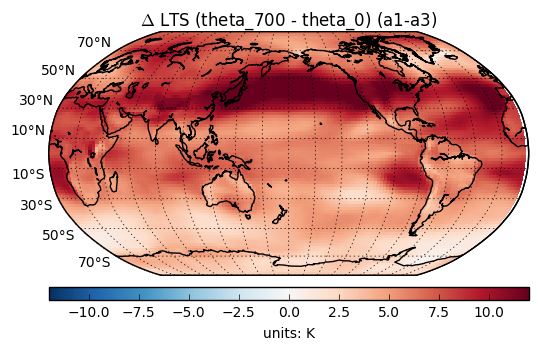

In [98]:
ttl_main = '$\Delta$ LTS (theta_700 - theta_0) (a1-a3)'
filename = var+ '%.2f' % lev[h]

var = 'T'

clim_abs = [580,880]
clim_diff = [-12,12]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case

mapdata = LTS_1 - LTS_2
print(np.max(mapdata),np.min(mapdata))
print(np.shape(LTS_1))
print(np.max(mapdata))

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


In [78]:
#print(ds1.var)
print(ds1.Z3.long_name)
print(ds1.PSL.long_name)
print(ds1.PS.long_name)
print(np.shape(ds1.Z3.values[:]))


Geopotential Height (above sea level)
Sea level pressure
Surface pressure
(12, 30, 96, 144)
<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:        (ilev: 31, lat: 96, lev: 30, lon: 144, nbnd: 2, time: 12)
Coordinates:
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 ...
  * lon            (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 ...
  * lev            (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * time           (time) object   10-02-01 00:00:00   10-03-01 00:00:00 ...
Dimensions without coordinates: nbnd
Data variables:
    gw             (lat) float64 0.0001367 0.001093 0.002185 0.003275 ...
    hyam           (lev) float64 0.003643 0.007595 0.01436 0.02461 0.03827 ...
    hybm           (lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P0             float64 1e+05
    hyai    

820.85836865
(30, 96, 144)
(96, 144)
4.73145


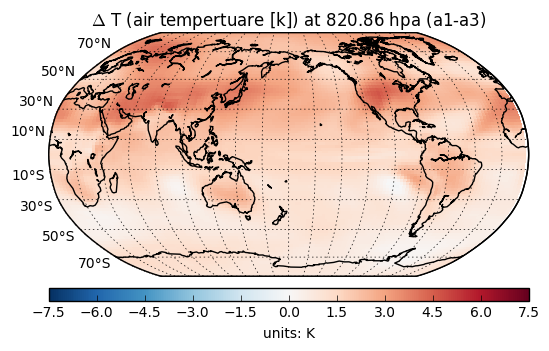

In [27]:
var = 'T'

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']

units = ds1[var].units

print(lev[22])

h = 22;

hpa = ds1['lev'][h]

ttl_main = '$\Delta$ T (air tempertuare [k]) at ' + '%.2f' % lev[h] + ' hpa (a1-a3)'
filename = var+ '%.2f' % lev[h]


clim_abs = [220,320]
clim_diff = [-7.5,7.5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
print(np.shape(mapdata_nan))
mapdata_nan = mapdata_nan[h,:,:].squeeze()
print(np.shape(mapdata_nan))
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

print(np.max(mapdata))
# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


-0.947368421053
200.0
312.5
(30, 45)
0.00330141


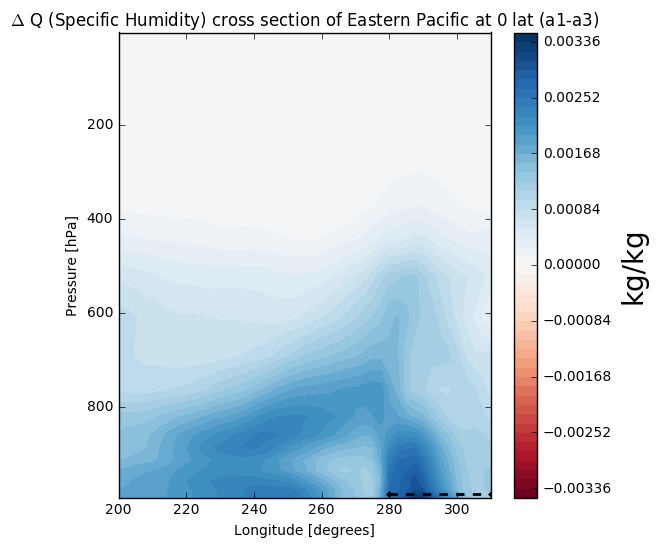

In [28]:
var = 'Q'

#print(ds1.var)

ds1 = ds_cam['global_a1_cv2_hc1_rs100']
ds2 = ds_cam['global_a3_cv2_hc1_rs100']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units

#units='g/kg'

hpa = ds1['lev'][20]

ttl = '$\Delta$ Q (Specific Humidity) cross section of Eastern Pacific at 0 lat (a1-a3)'
filename = var+'_cross_section'


clim_abs = [0,100]
clim_diff = [-0.0035, 0.0035]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#
#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

In [29]:
print(ds1.Q.long_name)

Specific humidity


## Repeat plots for rs3-rs200 case

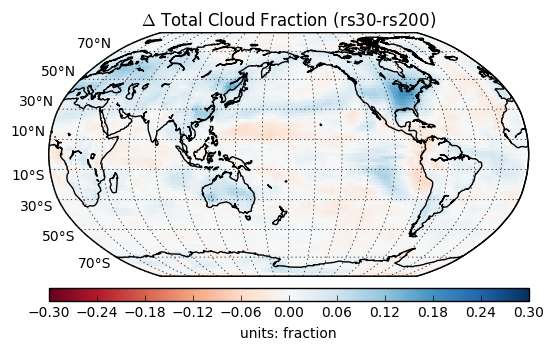

In [32]:
var = 'CLDTOT'

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']

units = ds1[var].units

ttl_main = '$\Delta$ Total Cloud Fraction (rs30-rs200)'
filename = var

clim_abs = [220,320]
clim_diff = [-.3,.3]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


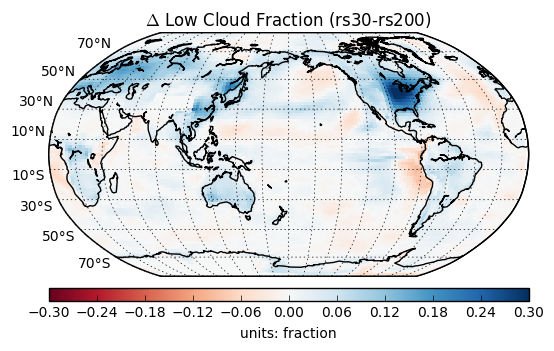

In [36]:
var = 'CLDLOW'

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']

units = ds1[var].units

ttl_main = '$\Delta$ Low Cloud Fraction (rs30-rs200)'
filename = var

clim_abs = [220,320]
clim_diff = [-.3,.3]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


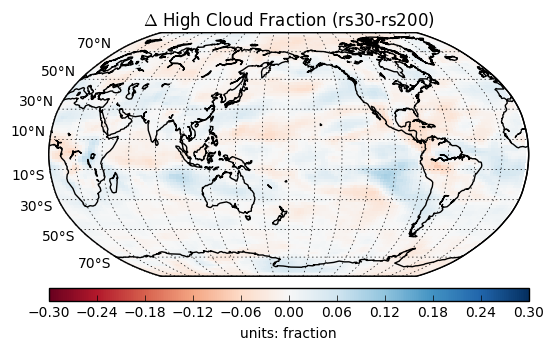

In [35]:
var = 'CLDHGH'

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']

units = ds1[var].units

ttl_main = '$\Delta$ High Cloud Fraction (rs30-rs200)'
filename = var

clim_abs = [220,320]
clim_diff = [-.3,.3]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata

# difference between darkest and brightest case
mapdata_nan = ds1.mean('time')[var].values.squeeze() - ds2.mean('time')[var].values.squeeze()
mapdata = np.ma.masked_where(np.isnan(mapdata_nan),mapdata_nan)

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)


-0.947368421053
200.0
312.5
(30, 45)
0.00138332


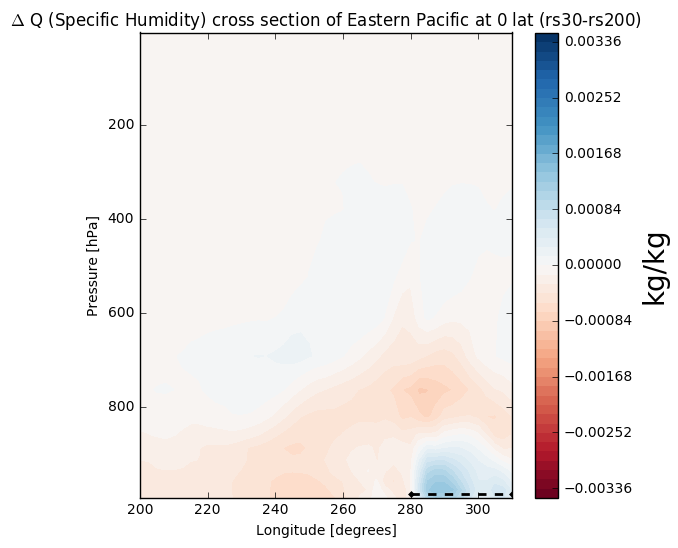

In [30]:
var = 'Q'

#print(ds1.var)

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units

#units='g/kg'

hpa = ds1['lev'][20]

ttl = '$\Delta$ Q (Specific Humidity) cross section of Eastern Pacific at 0 lat (rs30-rs200)'
filename = var+'_cross_section_rs'


clim_abs = [0,100]
clim_diff = [-0.0035, 0.0035]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#
#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

-0.947368421053
200.0
312.5
(30, 45)
0.107681
[200.0, 305.0]


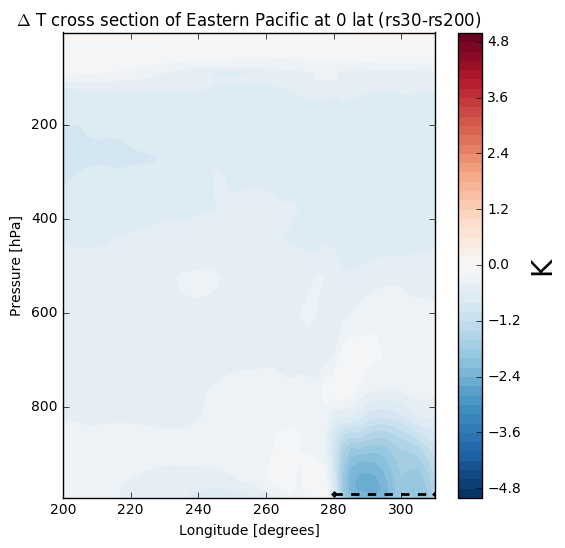

In [31]:
var = 'T'

#print(ds1.var)

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ T cross section of Eastern Pacific at 0 lat (rs30-rs200)'
filename = var+'_cross_section_Rs'


clim_abs = [0,1]
clim_diff = [-5,5]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

print([lon[xlon1],lon[xlon2-3]])

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#mp.plot([xlon1,xlon2],[950,950],'D-', markersize=10, linewidth=2, color='k', markerfacecolor='b')


#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

-0.947368421053
200.0
312.5
(30, 45)
15.9033


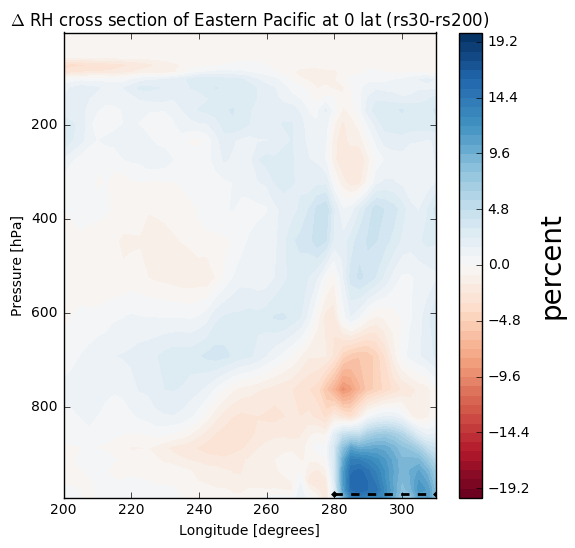

In [37]:
var = 'RELHUM'

#print(ds1.var)

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']
lat = ds1.lat.values
lon = ds1.lon.values
lev = ds1.lev.values
print(lat[47])
print(lon[80])
print(lon[125])
units = ds1[var].units



hpa = ds1['lev'][20]

ttl = '$\Delta$ RH cross section of Eastern Pacific at 0 lat (rs30-rs200)'
#ttl = '$\Delta$ RH cross section of Eastern Pacific at 0 lat (rs30-rs200)'

filename = var+'_cross_section_rs'


clim_abs = [0,100]
clim_diff = [-20, 20]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu

# -------------------------------
# Mapdata
xlat = 47;
xlon1 = 80
xlon2 = 125

# difference between darkest and brightest case
data = ds1.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze() - ds2.mean('time')[var].values[:,xlat,xlon1:xlon2].squeeze()
#data2 = np.flipud(data)
#data2 = np.fliplr(data)
#lev2 = np.flipud(lev)
#lon2 = np.flipud(lon[xlon1:xlon2])
data2 = data;
lev2 = lev;
lon2 = lon[xlon1:xlon2]


print(np.shape(data))
print(np.max(data))

fig = plt.figure(figsize=(6,6))
#ax = fig.add_axes([0.1,0.1,0.8,0.8])
clim = clim_diff
levels = np.linspace(clim[0], clim[1], 51)
    
mp = plt.contourf(lon2,lev2,data2,levels,cmap=cmap_diff)
mp.set_clim(vmin=clim[0],vmax=clim[1])
plt.gca().invert_yaxis()
ax=plt.gca();
#ax.set_yscale('log')
#mp.colorbar()
#cbar = plt.colorbar(mp,boundaries=np.linspace(clim[0], clim[1], 50))
#cbar = plt.colorbar(mp,vmin=clim[0],vmax=clim[1])
cbar = plt.colorbar(mp)
#cbar = 
cbar.set_label(units,fontsize=20)
#cbar.set_clim(vmin=clim[0],vmax=clim[1])
#cbar.ax.set_clim(vmin=clim[0],vmax=clim[1])
    
plt.title(ttl)
plt.ylabel('Pressure [hPa]')
plt.xlabel('Longitude [degrees]')

plt.plot([280,lon[xlon2-1]],[985,985],'D--', markersize=3, linewidth=2, color='k', markerfacecolor='k')
#
#tx = np.sin(np.array([-90,-60,-30,0,30,60,90])*np.pi/180)
#tx_name = ['-90','-60','-30','0','30','60','90']
#ax0.set_xticks(tx)
#ax0.set_xticklabels(tx_name)

### LTS

In [99]:
var = 'LTS'

ds1 = ds_cam['global_a2_cv2_hc1_rs30']
ds2 = ds_cam['global_a2_cv2_hc1_rs200']

lev = ds1.variables['lev'].values
h1 = 29
h2 = 20
print(lev[h1],lev[h2])
# We'll use 691 rather tahn 700 for theta_{700}

p1 = lev[h1];
p2 = lev[h2];

th0_1 = ds1.mean('time').variables['TREFHT'].values.squeeze()
th0_2 = ds2.mean('time').variables['TREFHT'].values.squeeze()

T700_1 = ds1.mean('time').variables['T'].values[h2,:,:].squeeze()
T700_2 = ds2.mean('time').variables['T'].values[h2,:,:].squeeze()

p0_1 = ds1.mean('time').variables['PS'].values.squeeze()
p0_2 = ds2.mean('time').variables['PS'].values.squeeze()

th700_1 = T700_1*(p0_1/p2)**0.286
th700_2 = T700_2*(p0_2/p2)**0.286

LTS_1 = th700_1 - th0_1
LTS_2 = th700_2 - th0_2



992.556095123 691.389430314


2.04163 -7.32312
(96, 144)
2.04163


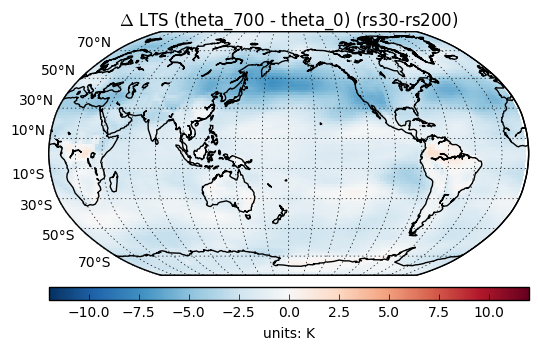

In [100]:
ttl_main = '$\Delta$ LTS (theta_700 - theta_0) (rs30-rs200)'
filename = var+ '%.2f' % lev[h]

var = 'T'

clim_abs = [580,880]
clim_diff = [-12,12]
cmap_abs = plt.cm.viridis
cmap_diff = plt.cm.RdBu_r

# -------------------------------
# Mapdata

# difference between darkest and brightest case

mapdata = LTS_1 - LTS_2
print(np.max(mapdata),np.min(mapdata))
print(np.shape(LTS_1))
print(np.max(mapdata))

# figure
fig, mp, ax, cbar, cs = mml_fig(LN,LT,mapdata,ds1,var,title=ttl_main,clim=clim_diff,colmap=cmap_diff,units=units)
